In [1]:
experiment_setup_name = "wikicat.long_run.category_focused.100s_batch.nesterov.3layer"

In [4]:
import sys
sys.path.append("/home/jheuristic/yozhik/")

from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

#the problem is too simple to be run on GPU. Seriously.
%env THEANO_FLAGS='device=cpu'

import theano

import theano.tensor as T
import lasagne


env: THEANO_FLAGS='device=cpu'


In [5]:

from AgentNet.config import snapshot_path

floatX = theano.config.floatX

from AgentNet.utils import create_shared,set_shared,in1d
from AgentNet.utils import save,load


AgentNet examples will store and seek thier snapshots at /home/jheuristic/yozhik/agentnet_snapshots/


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* 1000 нейронов
* с epsilon-greedy обучением
* Тупой SGD с Nesterov Mommentum


Много вспомогательного кода

# data
* a simple dataset where
* X1,X2,X3 are random booleans
* Y1 = (not X1) and X2
* Y2 = not Y1

In [6]:

df = pd.DataFrame(np.random.randint(0,2,[1000,3]),columns=["X1","X2","X3"])
df["Y1"] = np.logical_and(np.logical_not(df.X1), df.X2).astype(int)
df["Y2"] = 1 - df["Y1"]

In [7]:

df["Y1"] = np.logical_not(df.X1).astype(int)
df["Y2"] = 1 - df["Y1"]
df[:5]

,X1,X2,X3,Y1,Y2
0,1,1,1,0,1
1,0,0,1,1,0
2,0,0,1,1,0
3,1,0,1,0,1
4,0,0,1,1,0


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
train,test = train_test_split(df,test_size=0.9,random_state=42)

feature_names = df.columns
print feature_names
print "обучающая выборка:" ,len(train)
print "контрольная выборка:", len(test)

Index([u'X1', u'X2', u'X3', u'Y1', u'Y2'], dtype='object')
обучающая выборка: 100
контрольная выборка: 900


In [10]:
train_attrs = train[["X1","X2","X3"]].values
train_cats = train[["Y1","Y2"]].values
test_attrs = test[["X1","X2","X3"]].values
test_cats = test[["Y1","Y2"]].values

# problem definition
* environment,
* rewards

In [20]:
from AgentNet.objective import BaseObjective
from AgentNet.environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = create_shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  create_shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = self._attributes.shape[0]

        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1).astype('float32')
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
    
    
    
    def get_action_results(self,last_state,action,time_i):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,session_states,session_actions,batch_i):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[batch_id, memory_id]: environment state before taking action
            session_actions int[batch_id]: agent action at this tick
        returns:
            reward float[batch_id]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = in1d(session_actions, self._category_action_ids)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*4-2,
            _response*2-1
        )
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            0,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [21]:
env = CategoryGuess(3,2,5)

# agent setup

In [22]:
from AgentNet.resolver import EpsilonGreedyResolver
from AgentNet.memory import GRUMemoryLayer
from AgentNet.agent import Agent

In [23]:
import lasagne

n_hid=11


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")
_prev_state_layer = lasagne.layers.InputLayer([None,n_hid],name="prev_state_input")
#memory
gru = GRUMemoryLayer(n_hid,
                     _observation_layer,
                     _prev_state_layer,
                     name="gru0")

#q_eval
q_eval = lasagne.layers.DenseLayer(gru,num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = create_shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")


#all together
agent = Agent(gru,q_eval,resolver)


In [24]:
history = agent.get_sessions(env,session_length=10,
                       batch_size=env._joint_data.shape[0],)
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [25]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# weights

In [26]:
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [27]:
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru0.W_in_to_updategate,
 gru0.W_hid_to_updategate,
 gru0.b_updategate,
 gru0.W_in_to_resetgate,
 gru0.W_hid_to_resetgate,
 gru0.b_resetgate,
 gru0.W_in_to_hidden_update,
 gru0.W_hid_to_hidden_update,
 gru0.b_hidden_update]

# objective function

In [28]:
#get pairs of corresponding [predicted Qvalues, reference Qvalues] to train on

is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = create_shared('q_learning_gamma',np.float32(0.95),floatX)

ref_tuples = env.get_reference(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_Qvalues, predicted_Qvalues, is_end = ref_tuples

In [31]:
#concatenate "alive" ticks from all sessions to then compute errors

to_be_raveled = [action_seq,rewards_seq,action_Qvalues, predicted_Qvalues, is_end]

raveled_tuples = env.ravel_alive(is_alive_seq,*to_be_raveled)

action_ids_ravel,immediate_rewards_ravel,action_Qvalues_ravel,\
reference_Qvalues_ravel,is_end_ravel= raveled_tuples



from AgentNet.utils import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

In [32]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,action_Qvalues_ravel).mean()

In [33]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [34]:
loss = loss_recurrent + reg_l2

In [35]:
_updates = lasagne.updates.nesterov_momentum(loss
                                             ,
                                             weights,learning_rate=0.05,momentum=0.5)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [36]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation

In [37]:
evaluation_fun = theano.function([],[action_ids_ravel,action_Qvalues_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [38]:
feature_names = list(train.columns)+["end_session_now"]
def print_session(n_sessions = 3,display=False):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i])

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


# training

In [39]:


def load_random_batch(env,attrs,cats,batch_size=10):
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [40]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [41]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.

epoch 100,loss 1.33648, greed 0.22951, rewards: ( train -0.24307, det_train 0.00000) 
rec 1.336 reg 0.001
epoch 200,loss 0.78176, greed 0.25804, rewards: ( train -0.02906, det_train 0.13333) 
rec 0.781 reg 0.001
epoch 300,loss 1.04522, greed 0.28565, rewards: ( train 0.56080, det_train 0.32000) 
rec 1.044 reg 0.002
epoch 400,loss 0.86649, greed 0.31234, rewards: ( train 0.15628, det_train 0.48800) 
rec 0.864 reg 0.002
epoch 500,loss 0.92724, greed 0.33817, rewards: ( train 0.22164, det_train 0.73920) 
rec 0.925 reg 0.002
epoch 600,loss 0.67778, greed 0.36314, rewards: ( train 0.48587, det_train 0.56528) 
rec 0.676 reg 0.002
epoch 700,loss 0.48193, greed 0.38730, rewards: ( train 0.46042, det_train 0.60875) 
rec 0.480 reg 0.002
epoch 800,loss 0.73229, greed 0.41066, rewards: ( train 0.46726, det_train 0.84788) 
rec 0.730 reg 0.002
epoch 900,loss 0.71787, greed 0.43326, rewards: ( train 0.33682, det_train 0.86309) 
rec 0.715 reg 0.003
Evaluation:

deterministic
#3: Y1 (1.450) -> -2.0 | #

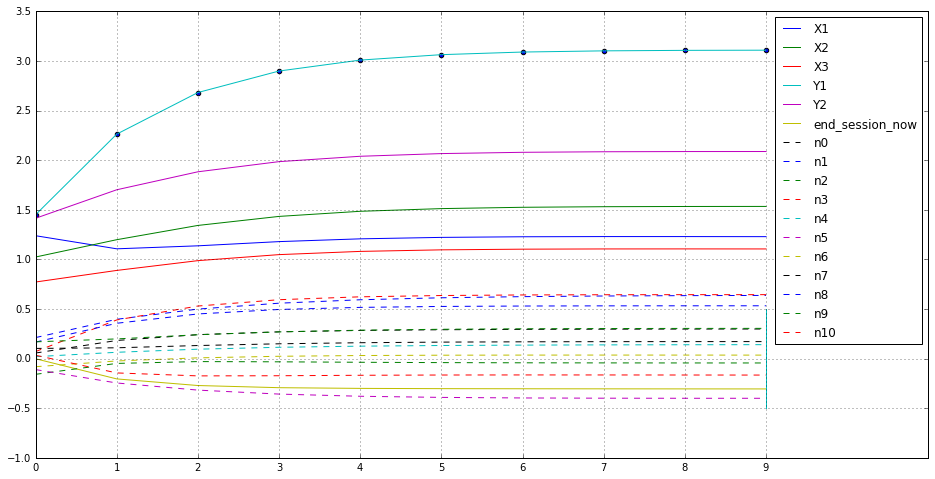



current_greediness (0.455122)
#3: Y1 (1.450) -> -2.0 | #3: Y1 (2.263) -> 0.0 | #3: Y1 (2.682) -> 0.0 | #0: X1 (1.179) -> 1.0 | #5: end_session_now (-0.109) -> 0.0 | <end>
true: Y2


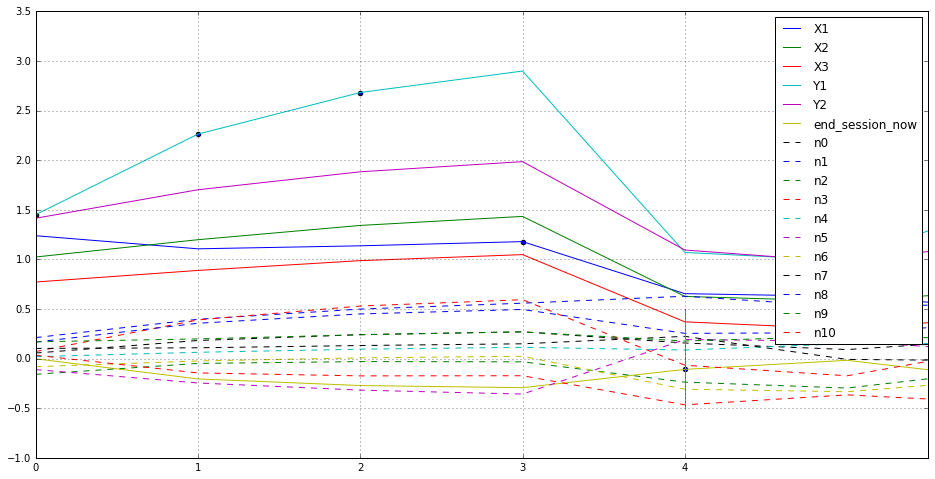

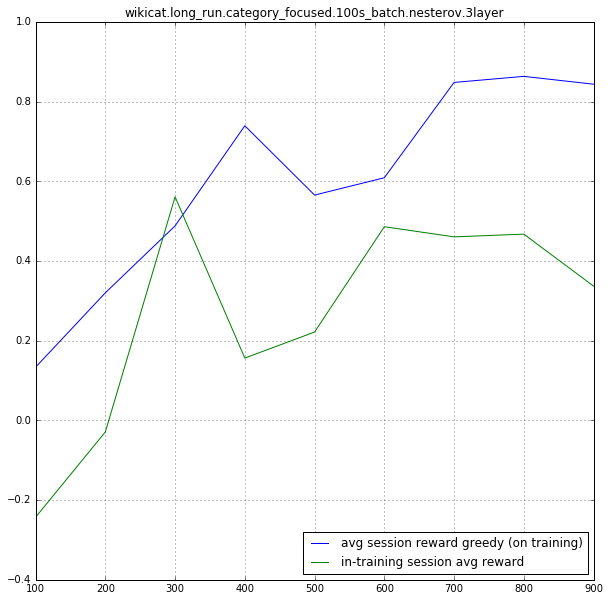

epoch 1000,loss 0.86412, greed 0.45512, rewards: ( train 0.26359, det_train 0.84345) 
rec 0.861 reg 0.003
epoch 1100,loss 0.62131, greed 0.47626, rewards: ( train 0.34505, det_train 0.62577) 
rec 0.618 reg 0.003
epoch 1200,loss 0.37805, greed 0.49671, rewards: ( train 0.33273, det_train 0.66319) 
rec 0.374 reg 0.004
epoch 1300,loss 0.45495, greed 0.51649, rewards: ( train 0.06503, det_train 0.66354) 
rec 0.451 reg 0.004
epoch 1400,loss 1.57566, greed 0.53562, rewards: ( train 0.51498, det_train 0.66385) 
rec 1.571 reg 0.005
epoch 1500,loss 0.57450, greed 0.55412, rewards: ( train 0.59538, det_train 0.76413) 
rec 0.569 reg 0.005
epoch 1600,loss 0.42553, greed 0.57202, rewards: ( train 1.30781, det_train 0.78772) 
rec 0.420 reg 0.005
epoch 1700,loss 0.55164, greed 0.58933, rewards: ( train 0.63820, det_train 0.87561) 
rec 0.546 reg 0.005
epoch 1800,loss 0.64711, greed 0.60607, rewards: ( train 0.60193, det_train 0.72139) 
rec 0.641 reg 0.006
epoch 1900,loss 0.69974, greed 0.62226, reward

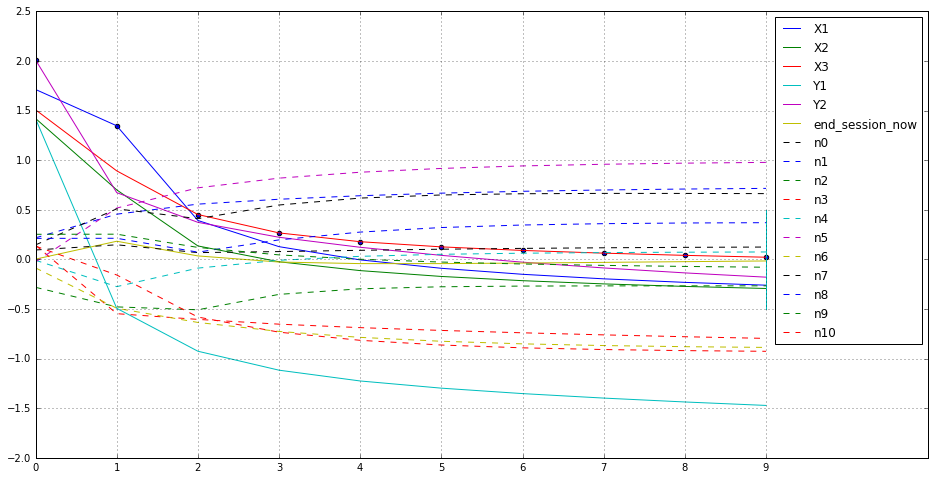



current_greediness (0.637925)
#4: Y2 (2.010) -> 2.0 | #0: X1 (1.347) -> 1.0 | #2: X3 (0.452) -> 1.0 | #2: X3 (0.267) -> 0.0 | #2: X3 (0.179) -> 0.0 | #2: X3 (0.126) -> 0.0 | #2: X3 (0.090) -> 0.0 | #3: Y1 (-1.398) -> -2.0 | #2: X3 (0.363) -> 0.0 | #1: X2 (-0.014) -> -1.0 | <end>
true: Y2


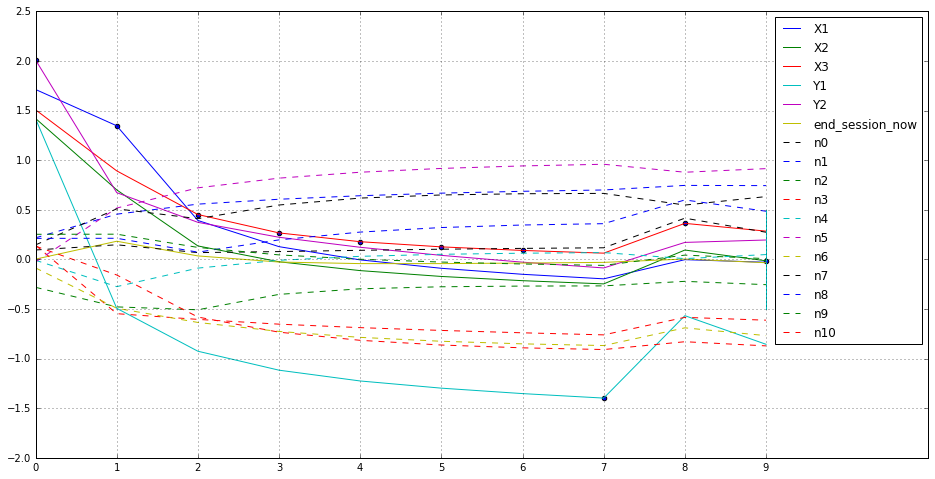

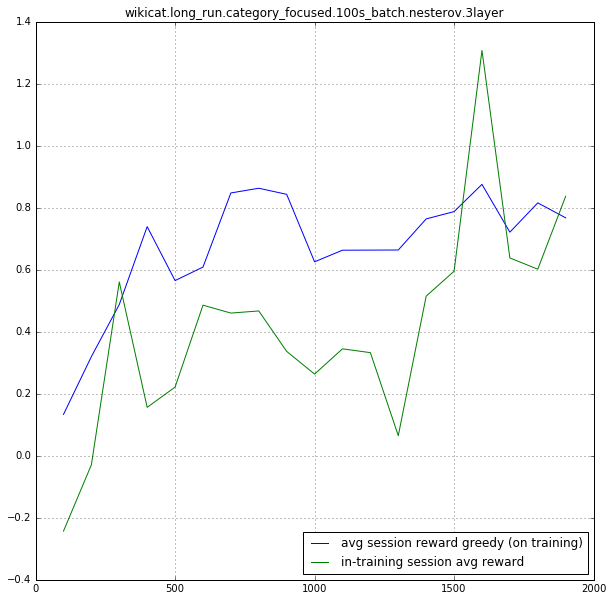

epoch 2000,loss 0.42143, greed 0.63792, rewards: ( train 0.79384, det_train 0.76766) 
rec 0.416 reg 0.006


In [ ]:
n_epochs = 10000
batch_size=3
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/3000.)*0.9),0.8)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1,True)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1,True)
        
        plot_scores(experiment_setup_name)

        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy
        
        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


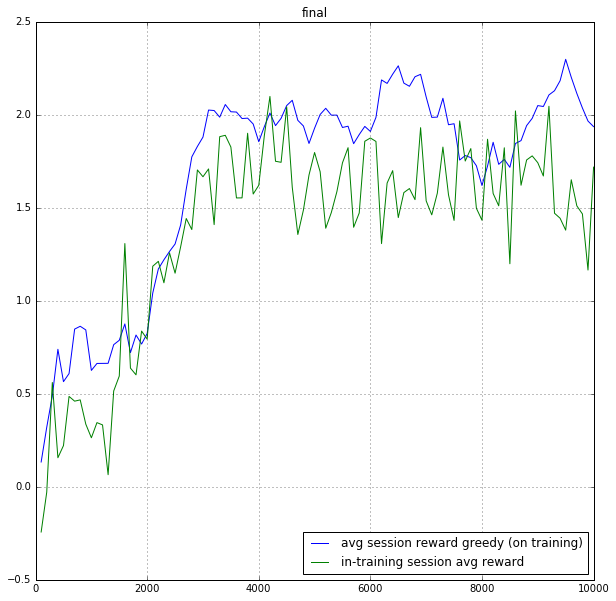

In [45]:
plot_scores("final")

#0: X1 (2.245) -> 1.0 | #4: Y2 (2.165) -> 2.0 | #0: X1 (0.038) -> 0.0 | #5: end_session_now (-0.000) -> 0.0 | <end>
true: Y2


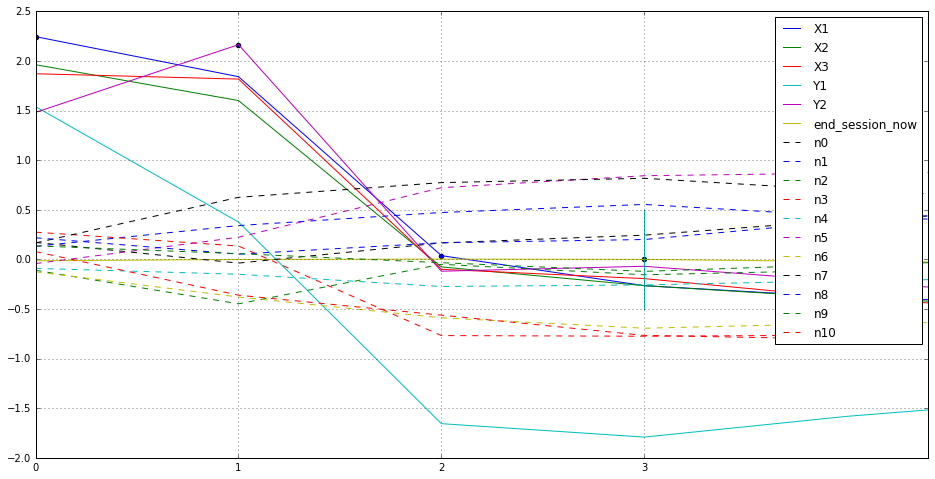


#0: X1 (2.245) -> -1.0 | #3: Y1 (2.128) -> 2.0 | #1: X2 (0.138) -> 1.0 | #0: X1 (0.015) -> 0.0 | #3: Y1 (0.081) -> 0.0 | #5: end_session_now (0.011) -> 0.0 | <end>
true: Y1


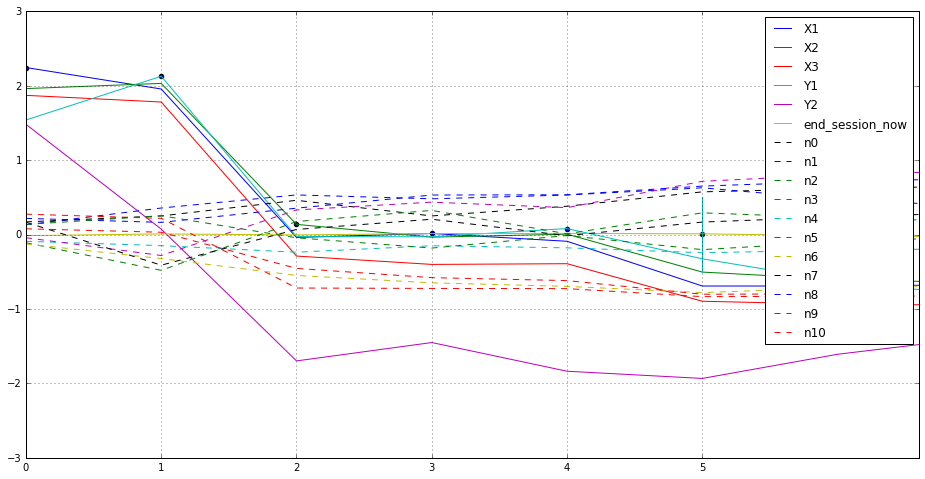


#5: end_session_now (-0.014) -> 0.0 | <end>
true: Y1


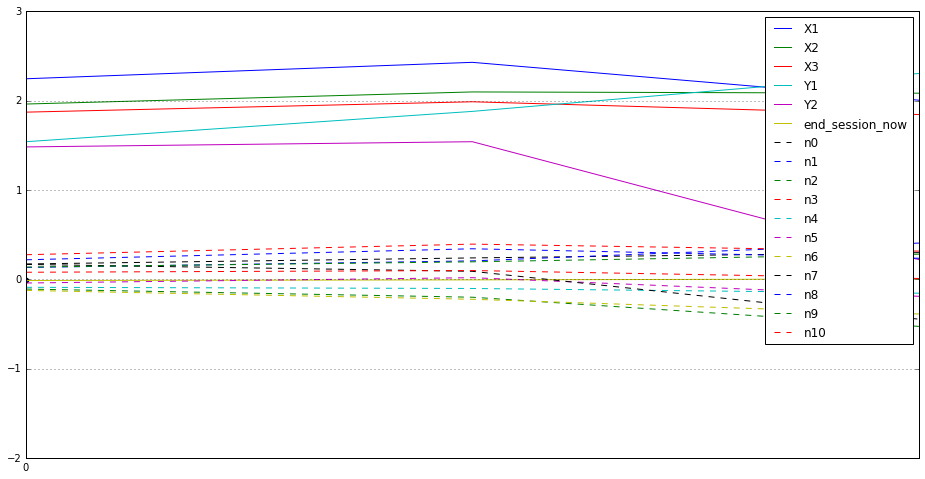

In [46]:
print_session(3,display=True)